In [314]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, precision_recall_curve, f1_score, auc
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [160]:
# We cant always reliably get the path the ipynb is in, so cwd is the hacky workaround
cwd = Path().absolute()
DATA_DIR = cwd / "data"
DATA_PATH = DATA_DIR / "adult.data"
TEST_PATH = DATA_DIR / "adult.test"

# Data exploration and cleaning

Quick note of some ideas:
- There are too many countries. Maybe just replace with a continent feature instead? Or with the countries gdp?
- Occupation is present as well. Wouldnt that have an almost direct correlation with salary?

Start with adult.data. The same transforms will apply to adult.test

In [271]:
adult_data = pd.read_csv(DATA_PATH, names=[
    "age", "workclass", "fnlwgt", "education",
    "education-num", "marital-status", "occupation",
    "relationship", "race", "sex", "capital-gain",
    "capital-loss", "hours-per-week", "native-country",
    "salary"
])

adult_test = pd.read_csv(TEST_PATH, names=[
    "age", "workclass", "fnlwgt", "education",
    "education-num", "marital-status", "occupation",
    "relationship", "race", "sex", "capital-gain",
    "capital-loss", "hours-per-week", "native-country",
    "salary"
])

# Drop first row of adult_test
# adult_test.drop(labels=0, axis=0, inplace=True)

In [162]:
adult_data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [163]:
adult_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  salary          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [164]:
adult_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16281 entries, 1 to 16281
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             16281 non-null  object 
 1   workclass       16281 non-null  object 
 2   fnlwgt          16281 non-null  float64
 3   education       16281 non-null  object 
 4   education-num   16281 non-null  float64
 5   marital-status  16281 non-null  object 
 6   occupation      16281 non-null  object 
 7   relationship    16281 non-null  object 
 8   race            16281 non-null  object 
 9   sex             16281 non-null  object 
 10  capital-gain    16281 non-null  float64
 11  capital-loss    16281 non-null  float64
 12  hours-per-week  16281 non-null  float64
 13  native-country  16281 non-null  object 
 14  salary          16281 non-null  object 
dtypes: float64(5), object(10)
memory usage: 1.9+ MB


<AxesSubplot:>

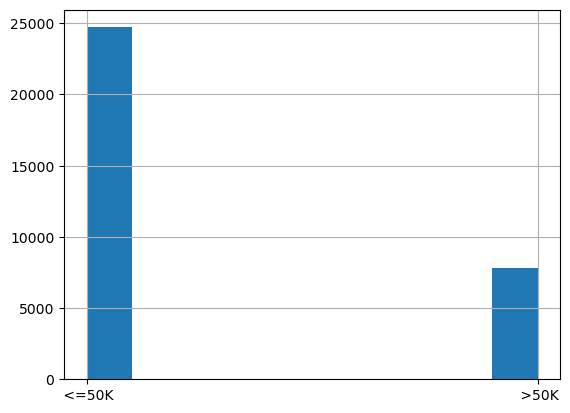

In [165]:
adult_data["salary"].hist()

<AxesSubplot:>

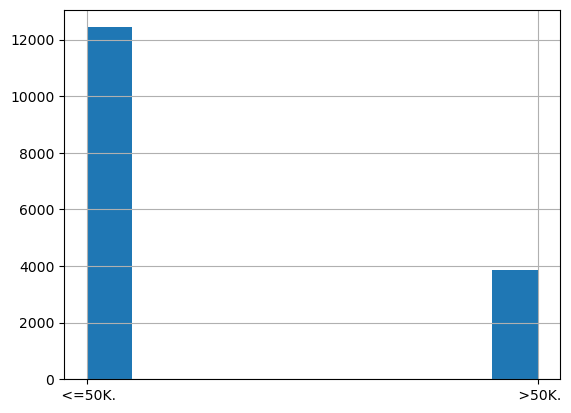

In [166]:
adult_test["salary"].hist()

**Age**

Check for missing values (denoted as ? in dataset)

In [167]:
adult_data.loc[adult_data["age"] == '?'].count().sum()

0

In [168]:
adult_test.loc[adult_data["age"] == '?'].count().sum()

0

In [169]:
# Cast adult_test age to int64
adult_test["age"] = adult_test["age"].astype(np.int64) 

**workclass**

In [170]:
adult_data["workclass"].unique()

array([' State-gov', ' Self-emp-not-inc', ' Private', ' Federal-gov',
       ' Local-gov', ' ?', ' Self-emp-inc', ' Without-pay',
       ' Never-worked'], dtype=object)

In [171]:
adult_data["workclass"].value_counts()

 Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
 ?                    1836
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: workclass, dtype: int64

In [172]:
adult_test["workclass"].value_counts()

 Private             11210
 Self-emp-not-inc     1321
 Local-gov            1043
 ?                     963
 State-gov             683
 Self-emp-inc          579
 Federal-gov           472
 Without-pay             7
 Never-worked            3
Name: workclass, dtype: int64

I think we have more than enough data to be able to drop all ? classes

<AxesSubplot:>

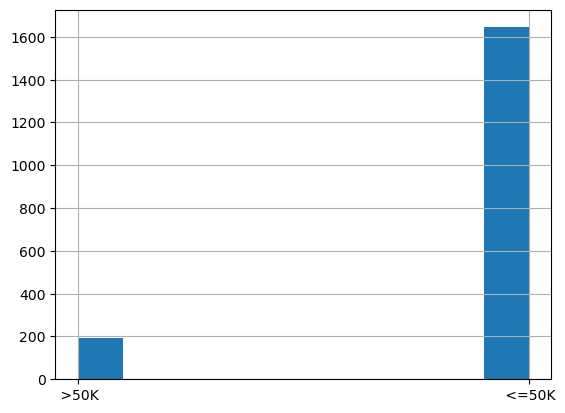

In [173]:
adult_data[adult_data["workclass"].str.contains('\?')]["salary"].hist()

The distribution of the rows we want to remove are similar to the distr of the pop as a whole (in terms of labels) so it should be ok.

<AxesSubplot:>

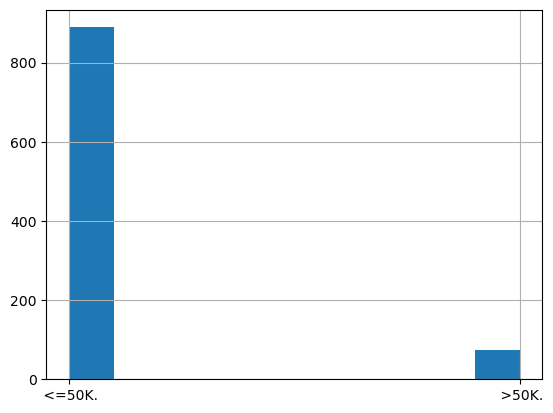

In [174]:
adult_test[adult_test["workclass"].str.contains('\?')]["salary"].hist()

**fnlweight**

Description of fnlweight:  

Description of fnlwgt (final weight)  
<br>
The weights on the CPS files are controlled to independent estimates of the  
civilian noninstitutional population of the US.  These are prepared monthly  
for us by Population Division here at the Census Bureau.  We use 3 sets of
controls.  
<br>
These are:  
         1.  A single cell estimate of the population 16+ for each state.  
         2.  Controls for Hispanic Origin by age and sex.  
         3.  Controls by Race, age and sex.  
We use all three sets of controls in our weighting program and "rake" through  
them 6 times so that by the end we come back to all the controls we used.  
<br>
The term estimate refers to population totals derived from CPS by creating  
"weighted tallies" of any specified socio-economic characteristics of the  
population.  
<br>
People with similar demographic characteristics should have  
similar weights.  There is one important caveat to remember  
about this statement.  That is that since the CPS sample is  
actually a collection of 51 state samples, each with its own  
probability of selection, the statement only applies within  
state.  


*So we need to figure out a way to only consider fnweight on state by state basis. Maybe standardize per state?*

In [175]:
# adult_test has fnlweight as float instead of int, we need to change that
adult_test["fnlwgt"] = adult_test["fnlwgt"].astype(np.int64)

In [176]:
adult_data["fnlwgt"].isna().sum()

0

In [177]:
adult_test["fnlwgt"].isna().sum()

0

<AxesSubplot:>

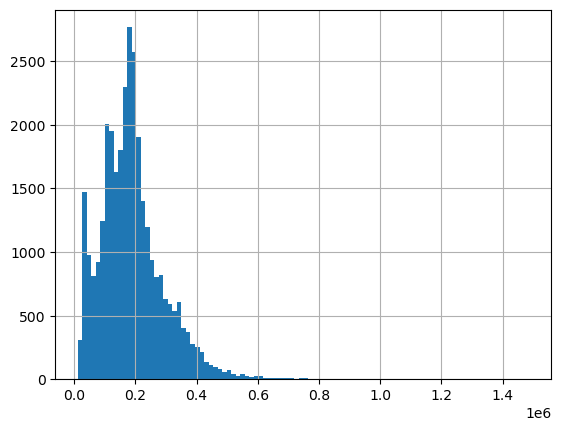

In [178]:
adult_data["fnlwgt"].hist(bins=100)

<AxesSubplot:>

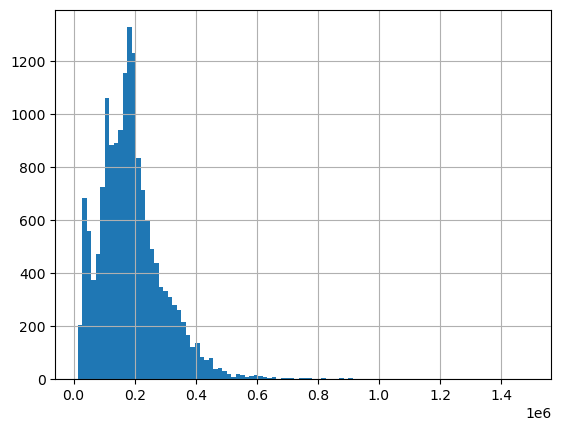

In [179]:
adult_test["fnlwgt"].hist(bins=100)

**education**

In [180]:
adult_data["education"].value_counts()

 HS-grad         10501
 Some-college     7291
 Bachelors        5355
 Masters          1723
 Assoc-voc        1382
 11th             1175
 Assoc-acdm       1067
 10th              933
 7th-8th           646
 Prof-school       576
 9th               514
 12th              433
 Doctorate         413
 5th-6th           333
 1st-4th           168
 Preschool          51
Name: education, dtype: int64

In [181]:
adult_data["education"].isna().sum()

0

In [182]:
adult_test["education"].value_counts()

 HS-grad         5283
 Some-college    3587
 Bachelors       2670
 Masters          934
 Assoc-voc        679
 11th             637
 Assoc-acdm       534
 10th             456
 7th-8th          309
 Prof-school      258
 9th              242
 12th             224
 Doctorate        181
 5th-6th          176
 1st-4th           79
 Preschool         32
Name: education, dtype: int64

In [183]:
adult_test["education"].isna().sum()

0

**education_num**

In [184]:
grouped_adult = adult_data.groupby("education-num")
for group in grouped_adult:
    print(group[0])
    print(group[1]["education"].unique())

1
[' Preschool']
2
[' 1st-4th']
3
[' 5th-6th']
4
[' 7th-8th']
5
[' 9th']
6
[' 10th']
7
[' 11th']
8
[' 12th']
9
[' HS-grad']
10
[' Some-college']
11
[' Assoc-voc']
12
[' Assoc-acdm']
13
[' Bachelors']
14
[' Masters']
15
[' Prof-school']
16
[' Doctorate']


In [185]:
# So we can simply drop education, since education level already encodes for it

In [186]:
grouped_adult_test = adult_test.groupby("education-num")
for group in grouped_adult:
    print(group[0])
    print(group[1]["education"].unique())

1
[' Preschool']
2
[' 1st-4th']
3
[' 5th-6th']
4
[' 7th-8th']
5
[' 9th']
6
[' 10th']
7
[' 11th']
8
[' 12th']
9
[' HS-grad']
10
[' Some-college']
11
[' Assoc-voc']
12
[' Assoc-acdm']
13
[' Bachelors']
14
[' Masters']
15
[' Prof-school']
16
[' Doctorate']


**marital-status**

If we want to perform feature reduction, we can probably do things like combining separated and married-spouse-absent or something. Though we might be losing some interesting information by doing that.

In [187]:
adult_data["marital-status"].unique()

array([' Never-married', ' Married-civ-spouse', ' Divorced',
       ' Married-spouse-absent', ' Separated', ' Married-AF-spouse',
       ' Widowed'], dtype=object)

In [188]:
adult_data["marital-status"].isna().sum()

0

In [189]:
adult_test["marital-status"].unique()

array([' Never-married', ' Married-civ-spouse', ' Widowed', ' Divorced',
       ' Separated', ' Married-spouse-absent', ' Married-AF-spouse'],
      dtype=object)

In [190]:
adult_test["marital-status"].isna().sum()

0

**occupation**

In [191]:
adult_data["occupation"].unique()

array([' Adm-clerical', ' Exec-managerial', ' Handlers-cleaners',
       ' Prof-specialty', ' Other-service', ' Sales', ' Craft-repair',
       ' Transport-moving', ' Farming-fishing', ' Machine-op-inspct',
       ' Tech-support', ' ?', ' Protective-serv', ' Armed-Forces',
       ' Priv-house-serv'], dtype=object)

<AxesSubplot:>

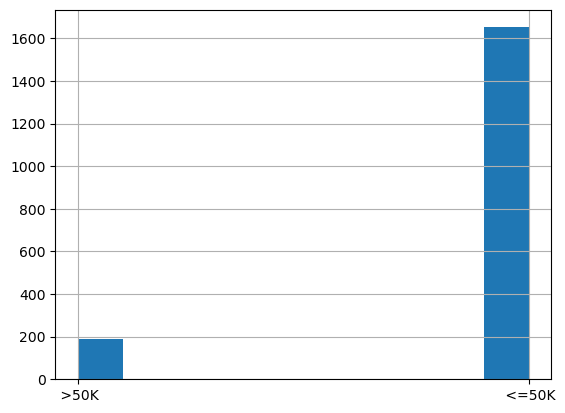

In [192]:
adult_data[adult_data["occupation"].str.contains('\?')]["salary"].hist()

In [193]:
adult_test["occupation"].unique()

array([' Machine-op-inspct', ' Farming-fishing', ' Protective-serv', ' ?',
       ' Other-service', ' Prof-specialty', ' Craft-repair',
       ' Adm-clerical', ' Exec-managerial', ' Tech-support', ' Sales',
       ' Priv-house-serv', ' Transport-moving', ' Handlers-cleaners',
       ' Armed-Forces'], dtype=object)

<AxesSubplot:>

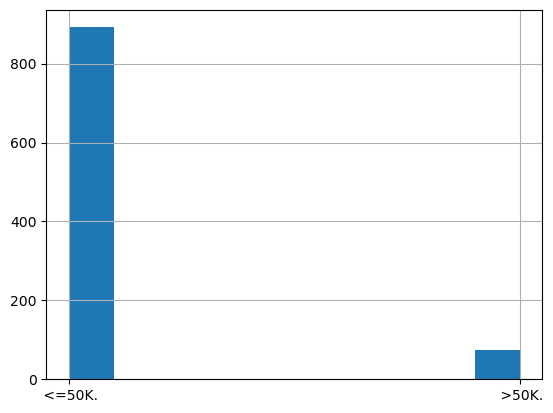

In [194]:
adult_test[adult_test["occupation"].str.contains('\?')]["salary"].hist()

We can drop all the ?

**relationship**

In [195]:
adult_data["relationship"].unique()

array([' Not-in-family', ' Husband', ' Wife', ' Own-child', ' Unmarried',
       ' Other-relative'], dtype=object)

In [196]:
adult_data["relationship"].value_counts()

 Husband           13193
 Not-in-family      8305
 Own-child          5068
 Unmarried          3446
 Wife               1568
 Other-relative      981
Name: relationship, dtype: int64

In [197]:
adult_test["relationship"].unique()

array([' Own-child', ' Husband', ' Not-in-family', ' Unmarried', ' Wife',
       ' Other-relative'], dtype=object)

In [198]:
adult_test["relationship"].value_counts()

 Husband           6523
 Not-in-family     4278
 Own-child         2513
 Unmarried         1679
 Wife               763
 Other-relative     525
Name: relationship, dtype: int64

**race**

In [199]:
adult_data["race"].value_counts()

 White                 27816
 Black                  3124
 Asian-Pac-Islander     1039
 Amer-Indian-Eskimo      311
 Other                   271
Name: race, dtype: int64

No need to drop ?

In [200]:
adult_test["race"].value_counts()

 White                 13946
 Black                  1561
 Asian-Pac-Islander      480
 Amer-Indian-Eskimo      159
 Other                   135
Name: race, dtype: int64

**sex**

In [201]:
adult_data["sex"].value_counts()

 Male      21790
 Female    10771
Name: sex, dtype: int64

In [202]:
adult_test["sex"].value_counts()

 Male      10860
 Female     5421
Name: sex, dtype: int64

**capital-gain**

In [203]:
adult_data["capital-gain"].isna().sum()

0

In [204]:
adult_test["capital-gain"].isna().sum()

0

**capital-loss**

In [205]:
adult_data["capital-loss"].isna().sum()

0

In [206]:
adult_test["capital-loss"].isna().sum()

0

In [207]:
adult_data["capital-loss"].describe()

count    32561.000000
mean        87.303830
std        402.960219
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       4356.000000
Name: capital-loss, dtype: float64

In [208]:
adult_test["capital-loss"].describe()

count    16281.000000
mean        87.899269
std        403.105286
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       3770.000000
Name: capital-loss, dtype: float64

**hours-per-week**

In [209]:
adult_data["hours-per-week"].isna().sum()

0

In [210]:
adult_data["hours-per-week"].describe()

count    32561.000000
mean        40.437456
std         12.347429
min          1.000000
25%         40.000000
50%         40.000000
75%         45.000000
max         99.000000
Name: hours-per-week, dtype: float64

In [211]:
adult_test["hours-per-week"].isna().sum()

0

In [212]:
adult_test["hours-per-week"].describe()

count    16281.000000
mean        40.392236
std         12.479332
min          1.000000
25%         40.000000
50%         40.000000
75%         45.000000
max         99.000000
Name: hours-per-week, dtype: float64

**native-country**

In [213]:
adult_data["native-country"].value_counts()

 United-States                 29170
 Mexico                          643
 ?                               583
 Philippines                     198
 Germany                         137
 Canada                          121
 Puerto-Rico                     114
 El-Salvador                     106
 India                           100
 Cuba                             95
 England                          90
 Jamaica                          81
 South                            80
 China                            75
 Italy                            73
 Dominican-Republic               70
 Vietnam                          67
 Guatemala                        64
 Japan                            62
 Poland                           60
 Columbia                         59
 Taiwan                           51
 Haiti                            44
 Iran                             43
 Portugal                         37
 Nicaragua                        34
 Peru                             31
 

<AxesSubplot:>

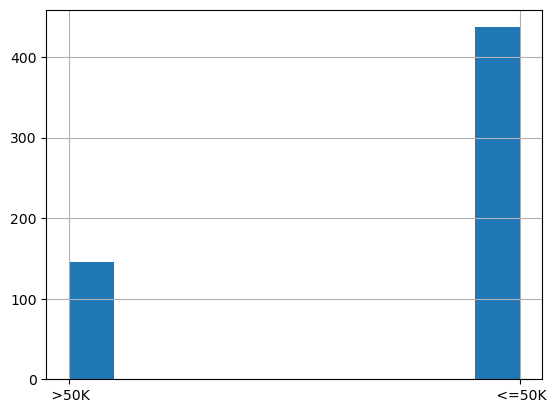

In [214]:
adult_data[adult_data["native-country"].str.contains('\?')]["salary"].hist()

<AxesSubplot:>

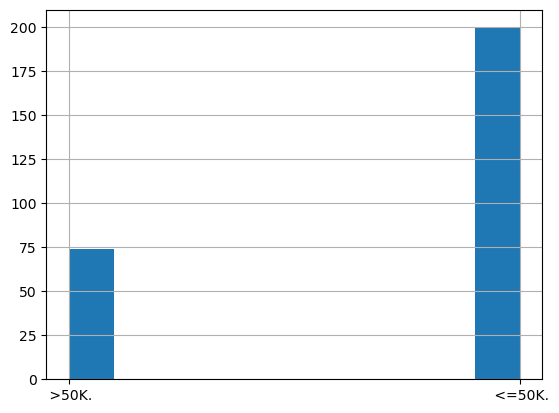

In [215]:
adult_test[adult_test["native-country"].str.contains('\?')]["salary"].hist()

# Preprocessing/Cleaning

In [272]:
def clean_adult(df):
    """
    Used to clean both the adult.data and the adult.test files.
    
    Columns must be renamed on import.
    """

    adf = df.copy()
    
    # Replace ? with np.nan
    adf.replace({"\?":np.nan}, regex=True, inplace=True)
    
    # Drop all rows with nans
    before = len(adf)
    adf.dropna(axis=0, inplace=True)
    after = len(adf)
    print("{} rows dropped due to missing data.".format(before - after))
    
    # Make sure all datatypes are properly set
    adf["age"] = adf["age"].astype(np.int64)
    adf["fnlwgt"] = adf["fnlwgt"].astype(np.int64)
    adf["education-num"] = adf["education-num"].astype(np.int64)
    adf["capital-gain"] = adf["capital-gain"].astype(np.int64)
    adf["capital-loss"] = adf["capital-loss"].astype(np.int64)
    adf["hours-per-week"] = adf["hours-per-week"].astype(np.int64)
    
    return adf

In [317]:
def preprocess(df, one_hot=[], drop_education=True, scale=[]):
    """
    NOTE: ONE HOT ENCODING SHOULD NOT BE USED WITH RANDOM FORESTS
    https://towardsdatascience.com/one-hot-encoding-is-making-your-tree-based-ensembles-worse-heres-why-d64b282b5769
    """
    
    adf = df.copy()
    
    # Convert the labels for salary to 1 and 0
    adf["salary"].replace({"<=50K":0, ">50K":1}, regex=True, inplace=True)
    
    # One hot encode all columns in one_hot
    for col in one_hot:
        temp = pd.get_dummies(adf[col])
        adf = adf.drop(col, axis=1)
        adf = adf.join(temp)
        
    # Drop the education column since it is already accounted for in education-num
    if drop_education:
        adf.drop("education", axis=1, inplace=True)
    
    # Scale the desired columns (center values around the column mean and std)
    if scale:
        scaler = StandardScaler()
        adf[scale] = scaler.fit_transform(adf[scale])
    
    return adf

In [327]:
adult_data = pd.read_csv(DATA_PATH, names=[
    "age", "workclass", "fnlwgt", "education",
    "education-num", "marital-status", "occupation",
    "relationship", "race", "sex", "capital-gain",
    "capital-loss", "hours-per-week", "native-country",
    "salary"
])

adult_test = pd.read_csv(TEST_PATH, names=[
    "age", "workclass", "fnlwgt", "education",
    "education-num", "marital-status", "occupation",
    "relationship", "race", "sex", "capital-gain",
    "capital-loss", "hours-per-week", "native-country",
    "salary"
])


In [ ]:
clean = clean_adult(adult_data)

In [331]:
dd = {"hi":"by"}
dd = ["f}"]

In [332]:
if type(dd) is not dict:
    print("hp")
else:
    print("lo")

hp
